Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

import os
from os import listdir
from os.path import isfile, join
import glob
pd.set_option('display.max_columns', 50)

#### Read all files and check the dfs

In [2]:
folder = "\Archive_14"
#folder = ""
households = pd.read_csv(f"..\Datalogs{folder}\Households.csv").sort_index(axis=1)
cons_firms = pd.read_csv(f"..\Datalogs{folder}\Consumer_Firms.csv").sort_index(axis=1)
cap_firms = pd.read_csv(f"..\Datalogs{folder}\Capital_Firms.csv").sort_index(axis=1)
pboard = pd.read_csv(f"..\Datalogs{folder}\Public_Info_Board.csv").sort_index(axis=1)
bank = pd.read_csv(f"..\Datalogs{folder}\Bank.csv").sort_index(axis=1)

Check dataframes

Get sums and averages for each timestep

In [3]:
households_sum = households.groupby('date').sum().reset_index()
households_avg = households.groupby('date').mean().reset_index()
cons_firms_sum = cons_firms.groupby('date').sum().reset_index()
cons_firms_avg = cons_firms.groupby('date').mean().reset_index()
cap_firms_sum = cap_firms.groupby('date').sum().reset_index()
cap_firms_avg = cap_firms.groupby('date').mean().reset_index()

Calculate number of agents

In [4]:
mask = households['date'].apply(lambda x: np.isnan(x) if isinstance(x, float) else False)

# filter dataframe using mask
filtered_df = households[mask]

timestep = int(households['date'].max())
#timestep = 15
n_households = households[households.date == 0].shape[0]
n_cons_firms = cons_firms[cons_firms.date == 0].shape[0]
n_cap_firms = cap_firms[cap_firms.date == 0].shape[0]
t = np.linspace(0,timestep, timestep +1)

In [5]:
print(f"Program has {n_households} households, {n_cons_firms} consumer firms, {n_cap_firms} capital firms, and runs for {timestep} timesteps")

Program has 10000 households, 400 consumer firms, 50 capital firms, and runs for 60 timesteps


## Plot the data

In [6]:
### Functions for plotting data

In [7]:
import matplotlib.pyplot as plt
import random

def plot_values(df, t, average, exclude_cols=[]):
    cols = [col for col in df.columns if col not in exclude_cols]
    num_plots = len(cols)
    num_cols = 3
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))
    axs = axs.flatten()

    for i, column in enumerate(cols):
        title = column + ": (average)" if average else column + ": (sum)"
        color = "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        axs[i].plot(t, df[column], label=title, color=color)
        axs[i].set_xlabel('Timestep')
        axs[i].set_ylabel('Values')
        axs[i].set_title(column)
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()


def plot_histogram(df, times, cols):
    # Plot histogram of each column at each of the times specified
    for col in cols:
        fig, axs = plt.subplots(nrows=1, ncols=len(times), figsize=(15, 5))
        for i, time in enumerate(times):

            axs[i].hist(df[df['date'] == time][col], bins=25)
            axs[i].set_xlabel(col)
            axs[i].set_ylabel('Frequency')
            axs[i].set_title(f'Distr of {col} at t={time}')
        plt.tight_layout()
        plt.show()


### Plot Households

##### Histograms

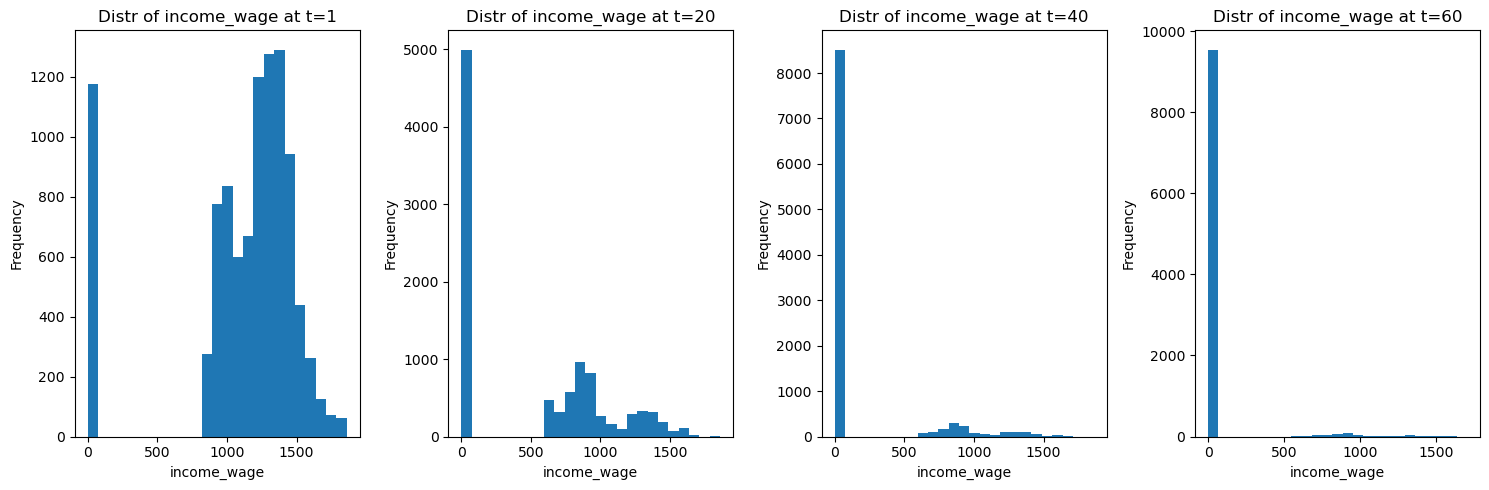

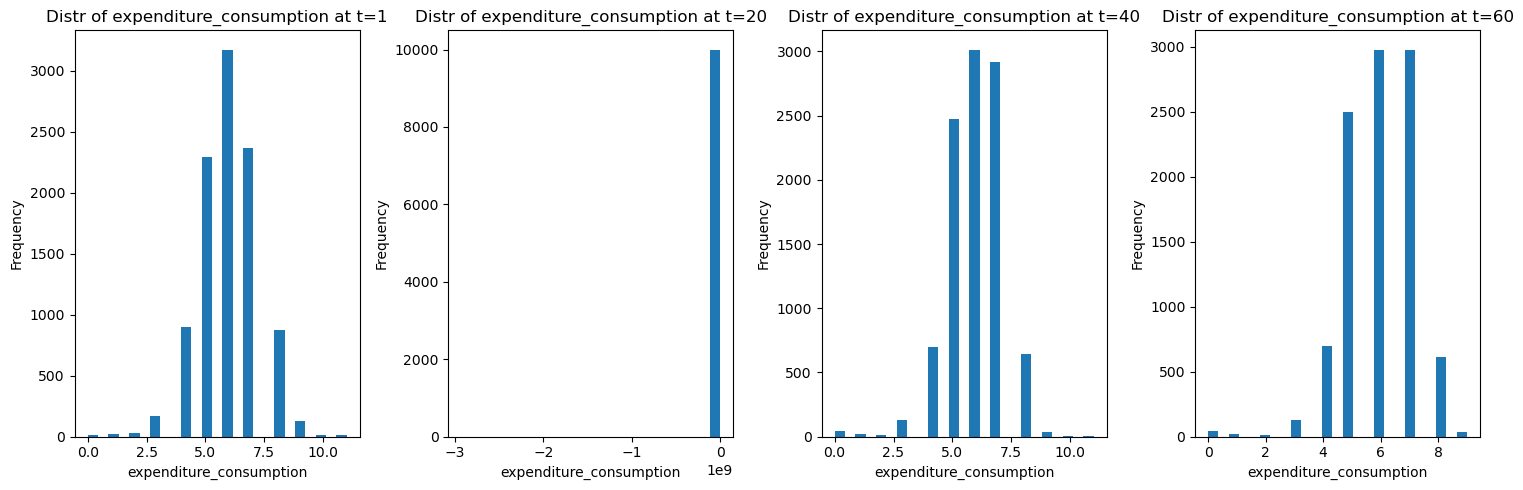

In [21]:
plot_histogram(households, [1, 20, 40, 60], [ 'income_wage', "expenditure_consumption"])

#### Plots

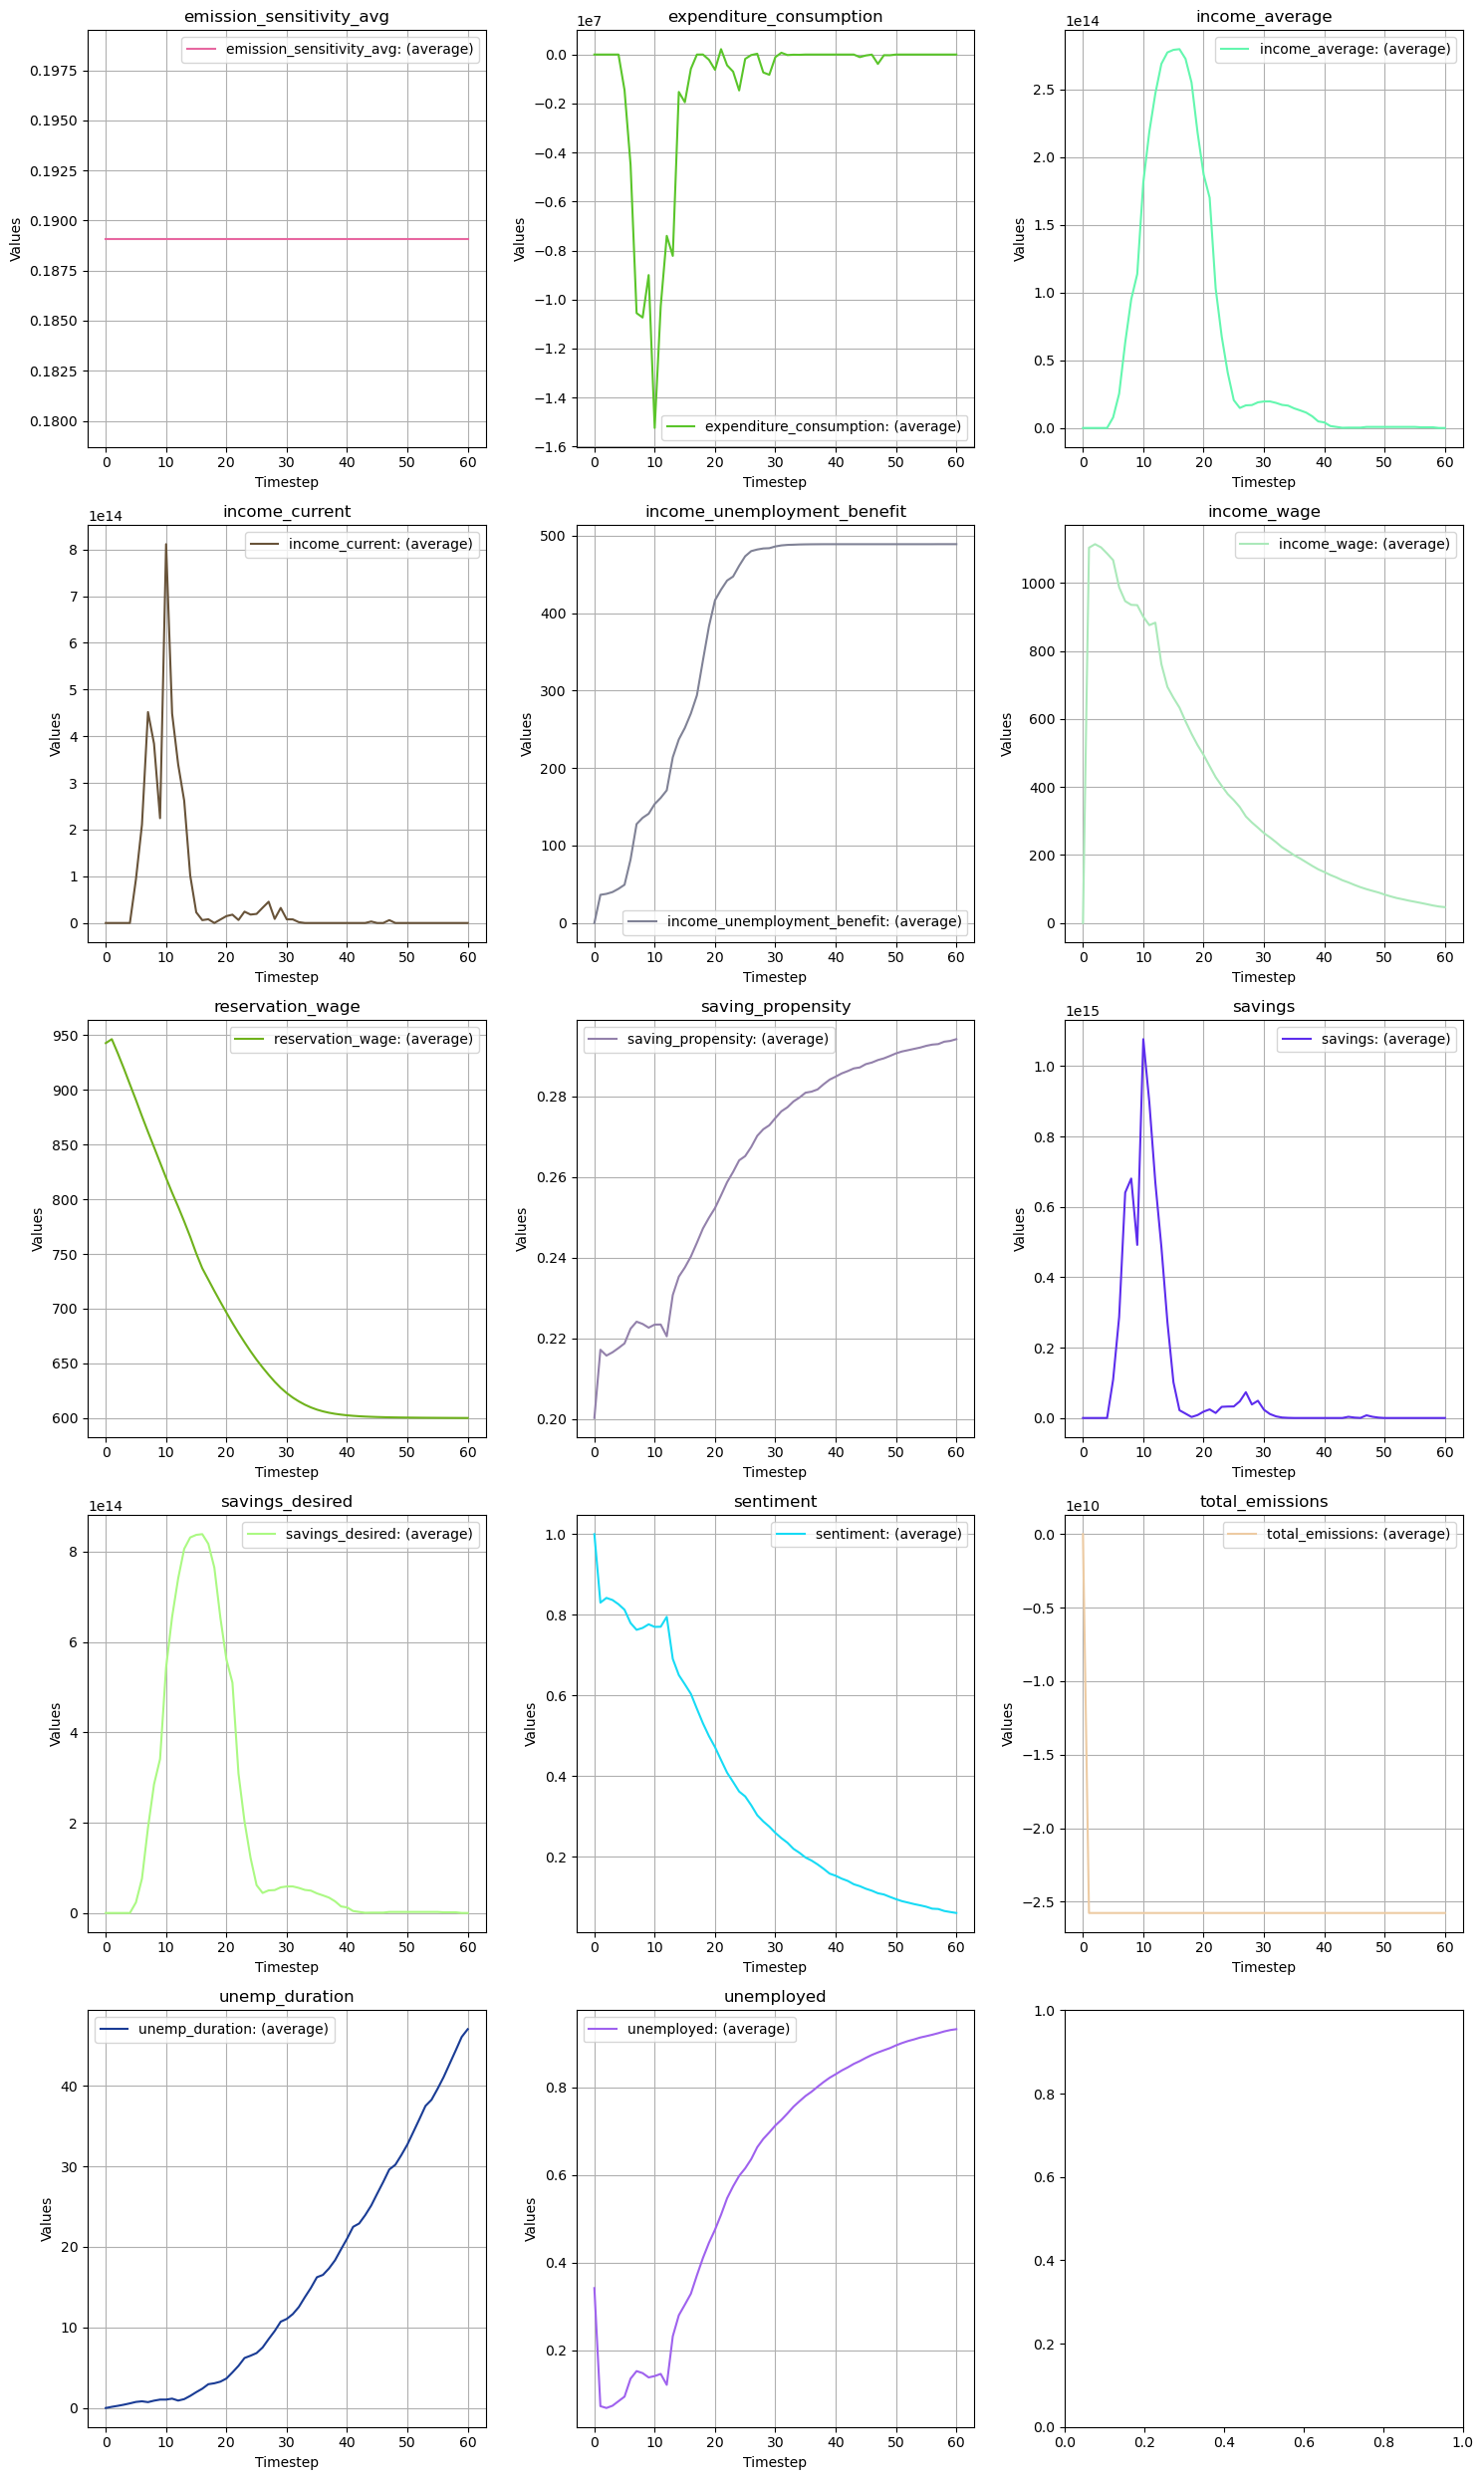

In [9]:
#cols_to_exclude = ['date']
#plot_values(households_sum,t,False, cols_to_exclude)
cols_to_exclude = ['date', "c_f", "c_h", "c_excess_money", "consumption_propensity", 
                   "expenditure_tax", "business_owner",
                   "saving_propensity_optimist", "saving_propensity_pessimist", "p_majority_op_adoption", "unemp_duration_upper_bound"] 
plot_values(households_avg,t,True, cols_to_exclude)

###  Plot firms

In [10]:
cols_to_exclude = ['date',"subsidies", "dividend_ratio", "dividend_ratio_optimistic", "dividend_ratio_pessimistic", "production_past",
                   "is_cons_firm", "inventory_reaction_factor", "desired_labor_capacity_utilization"]

#### Plot Consumer Firms

------ Plotting consumer firms -----


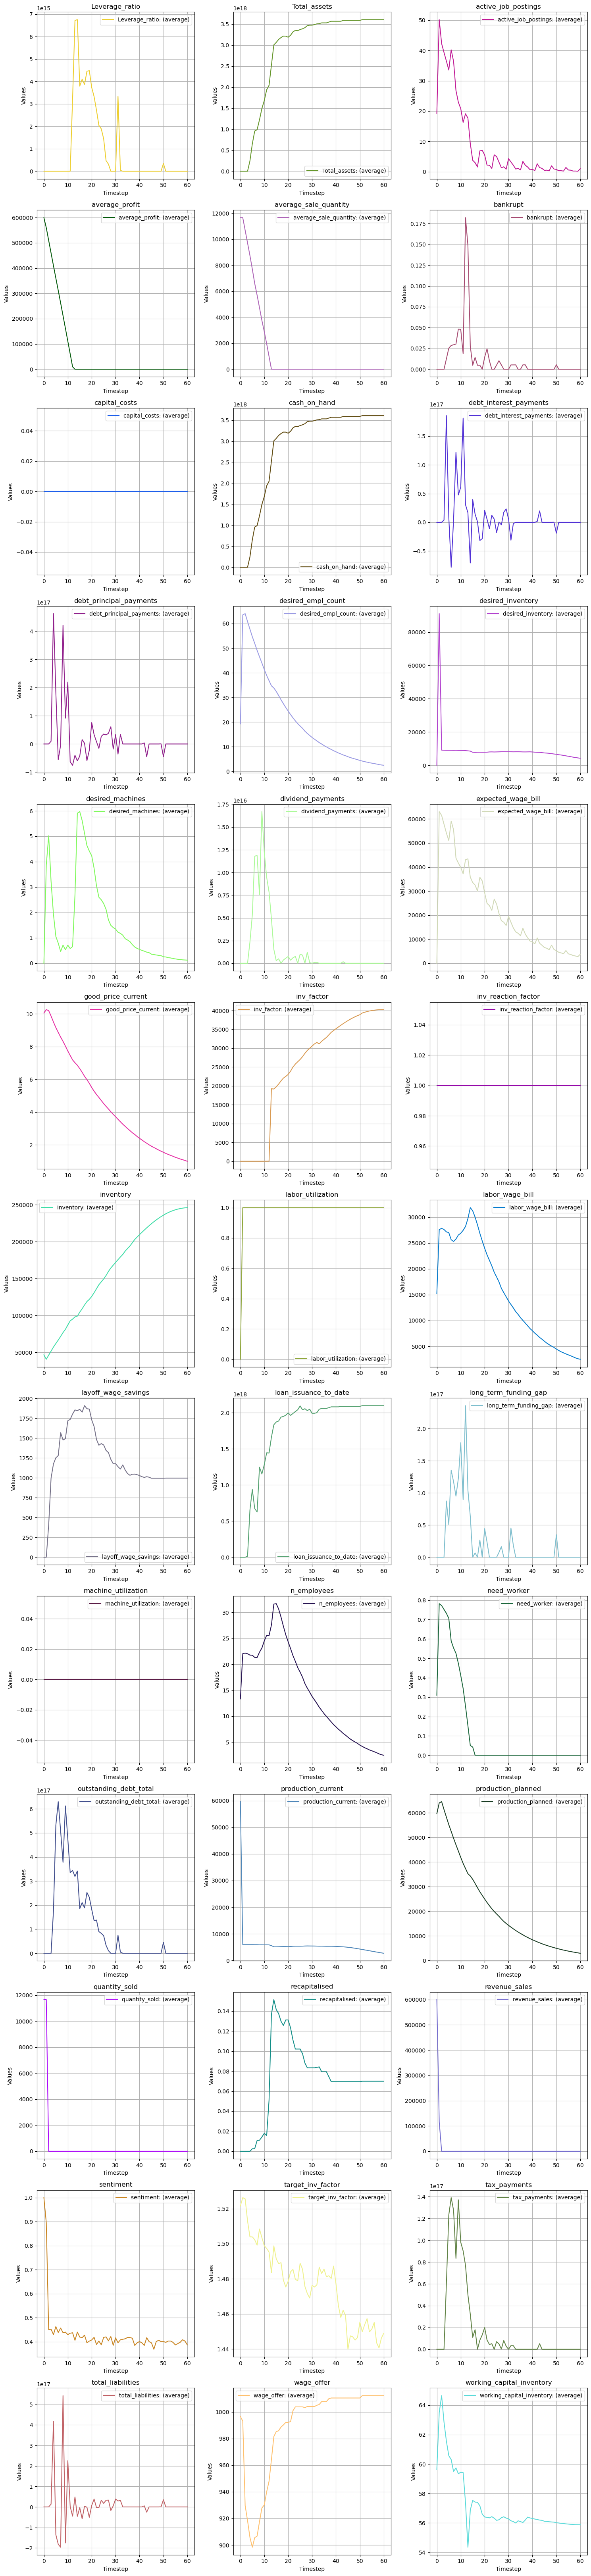

In [11]:
print("------ Plotting consumer firms -----")
#plot_values(cons_firms_sum,t,False, cols_to_exclude)

plot_values(cons_firms_avg,t,True, cols_to_exclude)

#### Histogram for Consumer Firms

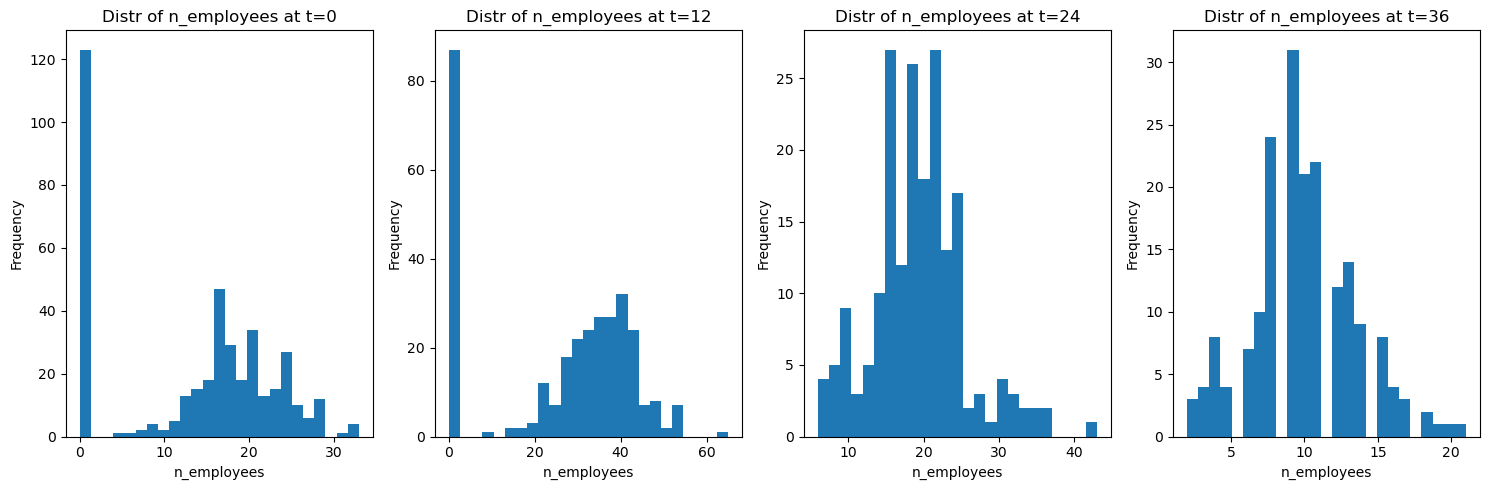

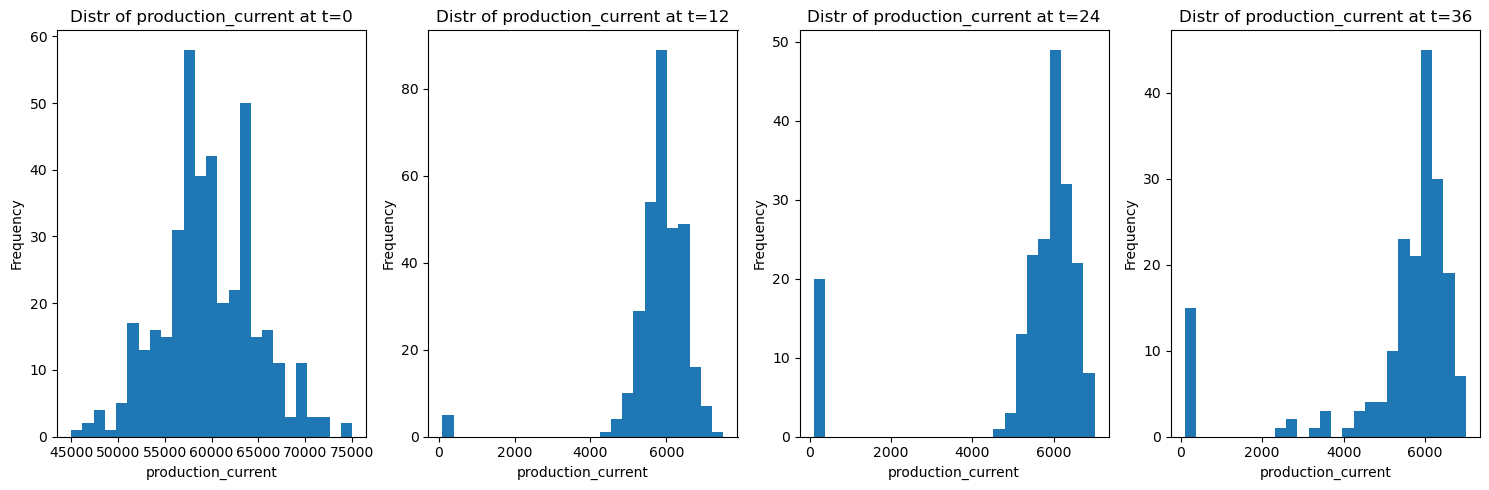

In [12]:
plot_histogram(cons_firms, [0, 12, 24, 36], [ 'n_employees', 'production_current'])

### Capital Firms

------ Plotting capital firms -----


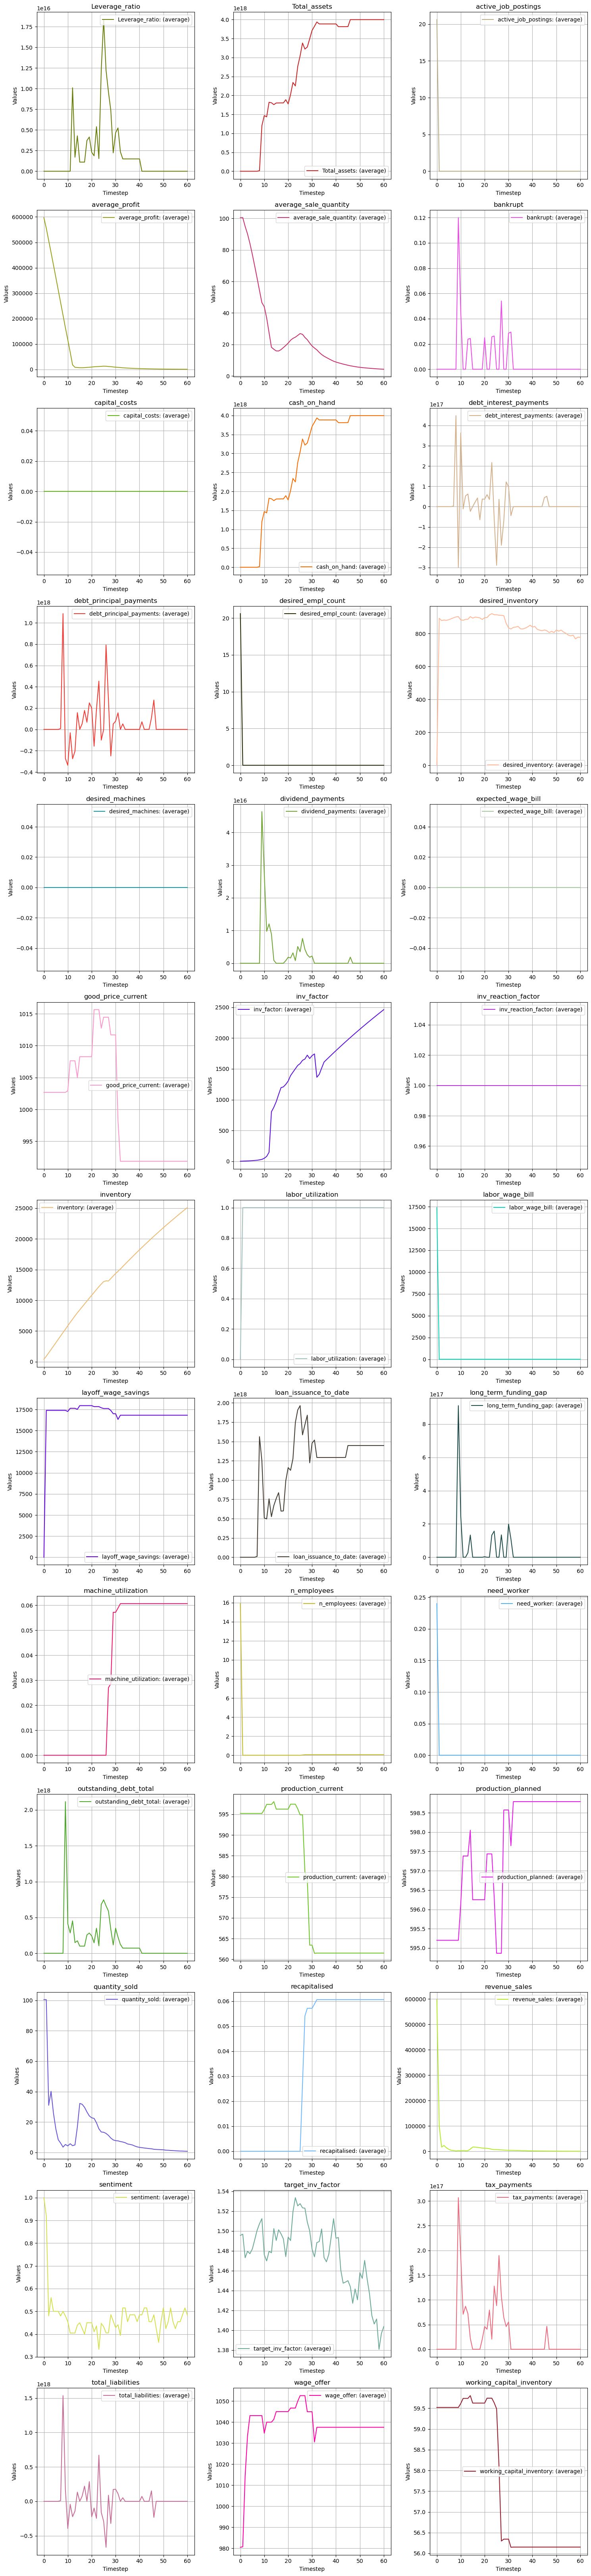

In [13]:
print("------ Plotting capital firms -----")
plot_values(cap_firms_avg,t,True, cols_to_exclude)

### Print Public Board

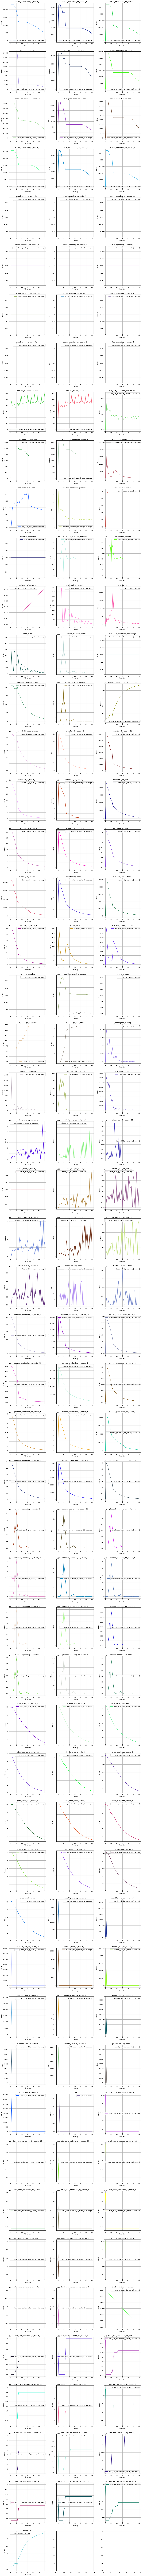

In [14]:
cols_to_exclude = ['date', "price_level_previous","cap_price_level_previous","n_employed", "n_unemployed", "cap_firm_sentiment_sum", 
                "cons_firm_sentiment_sum", "unempl_benefits"]
plot_values(pboard,t,True, cols_to_exclude)

# Bank

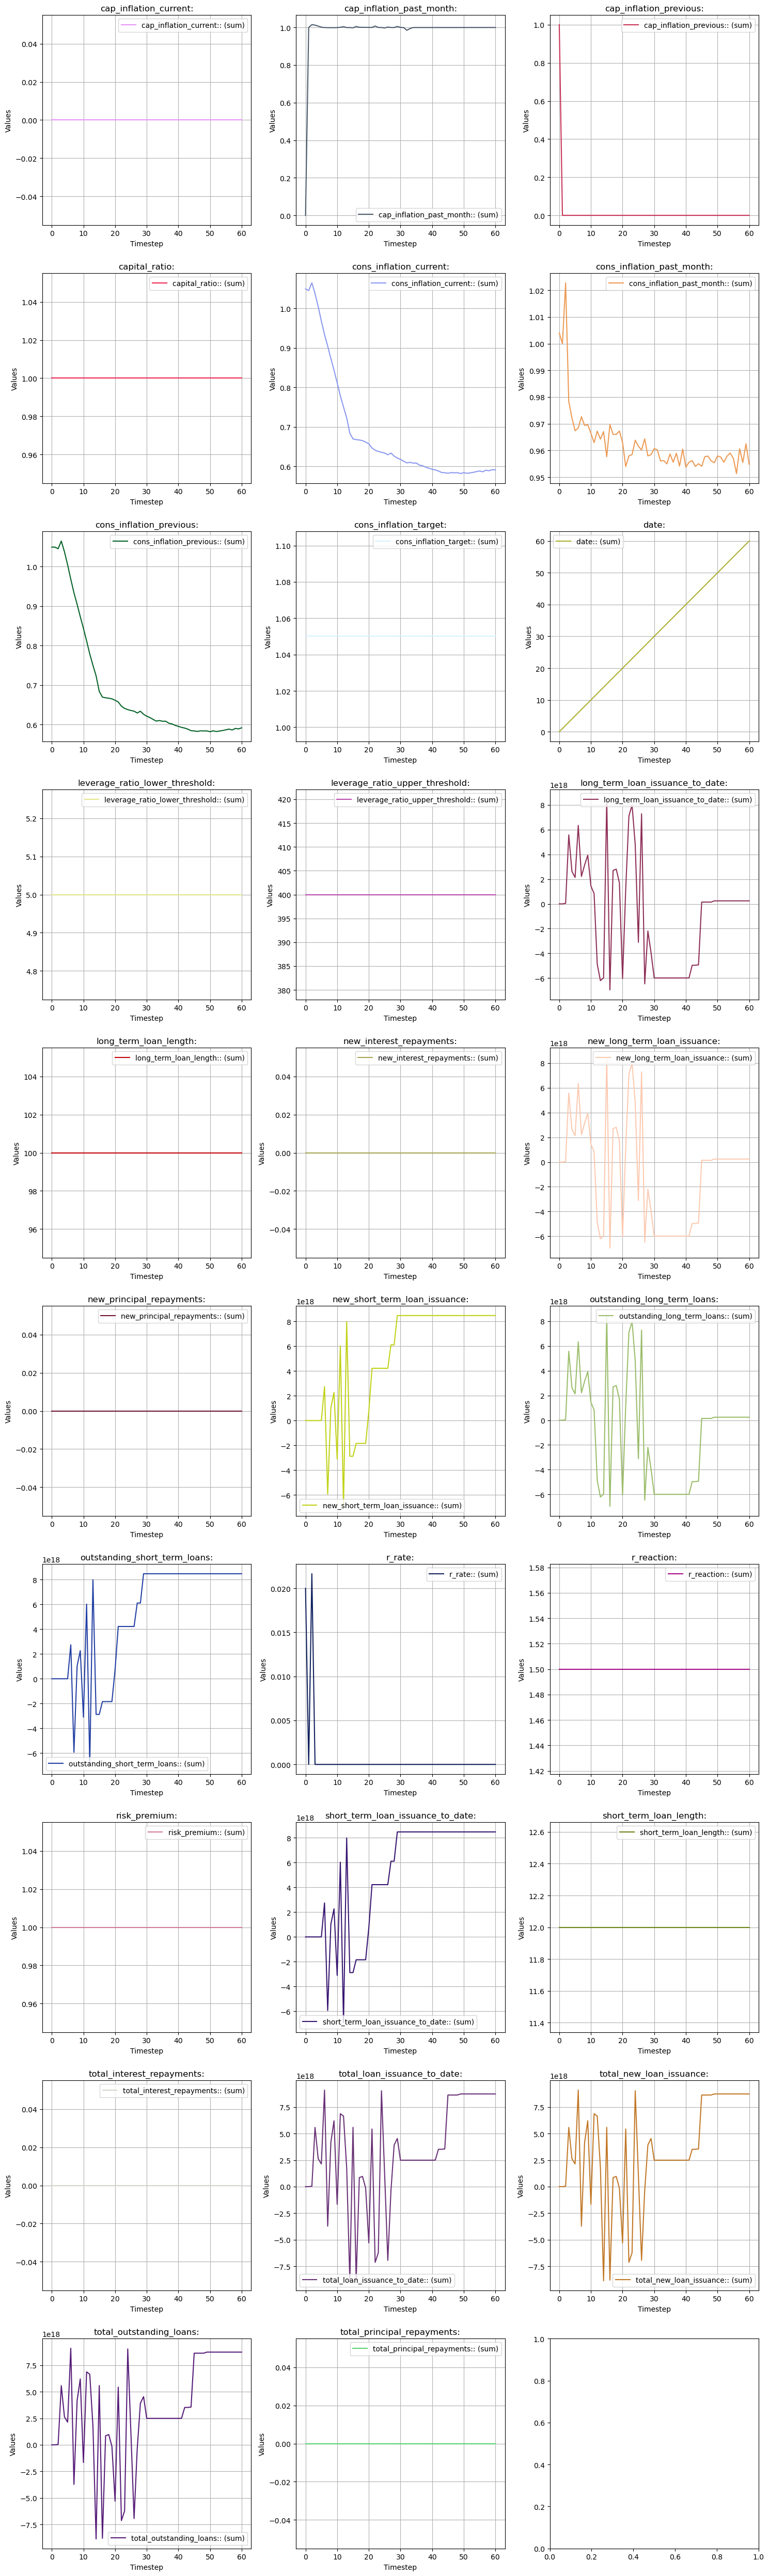

In [15]:
cols_to_exclude = ['date']
plot_values(bank,t,False, cols_to_exclude)

### Function to analyze distributions

In [16]:
def analyze_distribution(df, col_name, date):
    # Filter the DataFrame by date
    df_date = df[df['date'] == date]  # assuming the date column is named 'date'

    # Calculate statistics
    mean = df_date[col_name].mean()
    std = df_date[col_name].std()
    min_val = df_date[col_name].min()
    max_val = df_date[col_name].max()
    
    # Assuming the data follows a normal distribution, the bounds of the uniform
    # distribution that may have generated the data would be around the 3-sigma
    # range (as it contains about 99.7% of the data in a normal distribution).
    uniform_min = mean - 3 * std
    uniform_max = mean + 3 * std
    
    # Adjust the bounds to not exceed the actual min and max values
    uniform_min = max(uniform_min, min_val)
    uniform_max = min(uniform_max, max_val)

    result = {
        'mean': mean,
        'std': std,
        'min': min_val,
        'max': max_val,
        'uniform_distribution_bounds': (uniform_min, uniform_max)
    }

    return result

In [17]:
analyze_distribution(households, 'income_wage', 1)

{'mean': 1103.3593,
 'std': 448.61611991302175,
 'min': 0.0,
 'max': 1859.0,
 'uniform_distribution_bounds': (0.0, 1859.0)}

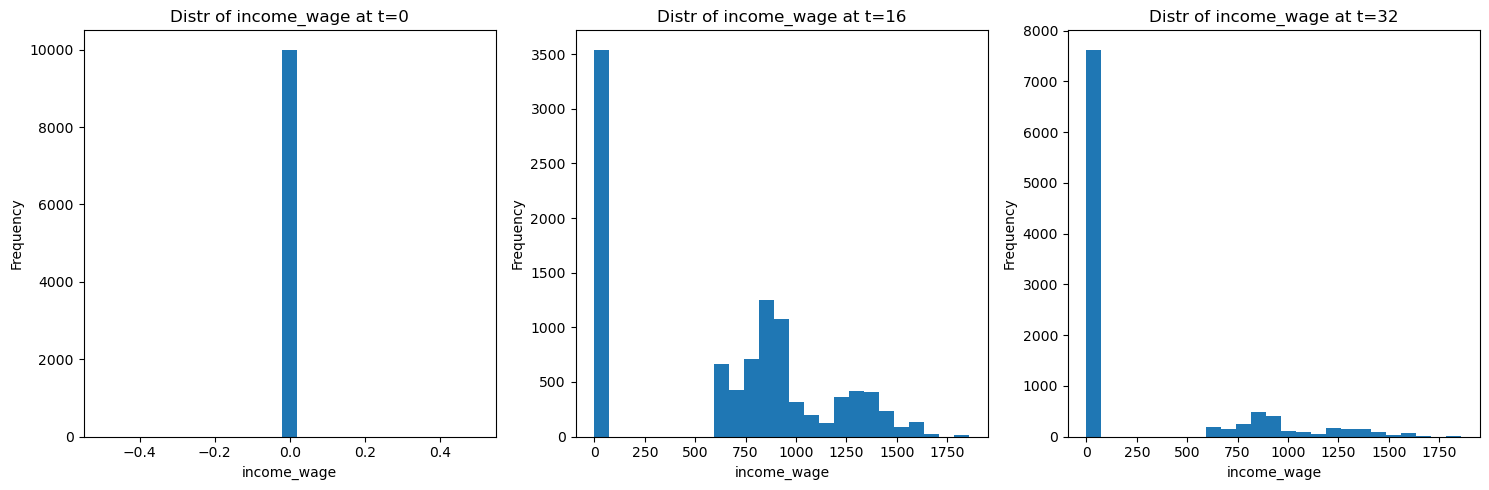

In [18]:
plot_histogram(households, [0, 16, 32], ["income_wage"])

### Function to plot multiple columns together

In [19]:
def plot_columns(df, *col_names):
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Define some colors (add more if needed)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i, col_name in enumerate(col_names):
        # Normalize the column to [0, 1] for plotting on the same graph
        column = df[col_name]
        normalized_column = (column - column.min()) / (column.max() - column.min())
        
        # Plot the column with a color
        plt.plot(df.index, normalized_column, color=colors[i % len(colors)], label=col_name)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [20]:
result = analyze_distribution(df, 'column_name')
print(result)

NameError: name 'df' is not defined